# 📊 Airbnb review/popularity Analysis

#### In this project we're exploring the features that either increase or decrease review/popularity of Airbnb's


In [192]:
# import our libaries

import pandas as pd 
import numpy as np 
import seaborn as sd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

listingsData = pd.read_csv('airbnb data/listings.csv')

#
important_columns = [
  # Targets
  'id','number_of_reviews_ltm', 'reviews_per_month', 'review_scores_rating',

  # Location
   'latitude', 'longitude',

  # Property
  'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'amenities', 'price',

  # Host
  'host_is_superhost', 'host_response_time', 'host_response_rate',
  'host_acceptance_rate', 'host_identity_verified',

  # Availability
  'availability_30', 'availability_365', 'minimum_nights', 'maximum_nights',

  # Review Scores
  'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
  'review_scores_communication', 'review_scores_location', 'review_scores_value'
]
#Taking the columns that I will be exploring or are important and exlucding columns like url's,names, and etc/
listingData = listingsData[important_columns]

listingData.info()
listingData['amenities']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45421 entries, 0 to 45420
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           45421 non-null  int64  
 1   number_of_reviews_ltm        45421 non-null  int64  
 2   reviews_per_month            32849 non-null  float64
 3   review_scores_rating         32849 non-null  float64
 4   latitude                     45421 non-null  float64
 5   longitude                    45421 non-null  float64
 6   property_type                45421 non-null  object 
 7   room_type                    45421 non-null  object 
 8   accommodates                 45421 non-null  int64  
 9   bedrooms                     42358 non-null  float64
 10  beds                         36545 non-null  float64
 11  amenities                    45421 non-null  object 
 12  price                        36405 non-null  object 
 13  host_is_superhos

0        ["Extra pillows and blankets", "Frigidaire gas...
1        ["Host greets you", "Free street parking", "Re...
2        ["Extra pillows and blankets", "Host greets yo...
3        ["Gym", "Free street parking", "First aid kit"...
4        ["Extra pillows and blankets", "Host greets yo...
                               ...                        
45416    ["Heating", "Dedicated workspace", "Bathtub", ...
45417    ["Heating", "Dedicated workspace", "Bathtub", ...
45418    ["Heating", "Dedicated workspace", "Bathtub", ...
45419    ["Stove", "Outdoor furniture", "Free parking o...
45420    ["Pets allowed", "Carbon monoxide alarm", "Was...
Name: amenities, Length: 45421, dtype: object

# Data Transformation

In [193]:
# removing listings with no reviews 
listingData = listingData[(listingData['review_scores_rating'].notna()) & (listingData['number_of_reviews_ltm'] != 0)]

# makes a column of number of ameneties for each listing
listingData['total_amenities'] = listingData['amenities'].apply(lambda x: len(eval(x)))

# clean amenities and make it into an actual list

listingData['amenities_list'] = listingData['amenities'].str.replace(r'[\[\]\"]','',regex= True).str.split(',')

#removes listing with no price and makes the column of price into float 
listingData = listingData[listingData['price'].notna()]
listingData['price'] = listingData['price'].str.replace(r'[$,]','',regex = True).astype(float)

# replace string percentages and convert into floats
listingData['host_response_rate'] = listingData['host_response_rate'].str.replace('%','').astype(float)
listingData['host_acceptance_rate'] = listingData['host_acceptance_rate'].str.replace('%','').astype(float)

# replace true or false columns with actual boolean values
TF_columns = ['host_is_superhost','host_identity_verified']

for x in TF_columns:
    listingData[x] = listingData[x].map({'t': True, 'f': False})


#deal with null values(small amount to remove)
sub_reviews = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
  'review_scores_communication', 'review_scores_location', 'review_scores_value']
fill_unknown = ['host_is_superhost','host_response_time','host_response_rate','host_acceptance_rate']

listingData['bedrooms'] = listingData['bedrooms'].fillna(1)
listingData['beds'] = listingData['beds'].fillna(1)

for x in fill_unknown:
    listingData[x] = listingData[x].fillna('unknown')
for x in sub_reviews:
    listingData = listingData[listingData[x].notnull()]
listingData = listingData[listingData['host_identity_verified'].notnull()]


#remove outliers
#check outliers using describe
listingData.describe()

outlierPrice = listingData['price'].quantile(0.99)
outlierNumOfReviews = listingData['number_of_reviews_ltm'].quantile(0.99)

listingData = listingData[(listingData['price'] <= outlierPrice) & (listingData['number_of_reviews_ltm'] <= outlierNumOfReviews)]

# should focus on established host and see what they do to have their level of reviews and have a lot of people booking their airbnb
# Ignoring noise consisting of inactive listing or listings that have barley any reviews
listingData = listingData[listingData['number_of_reviews_ltm'] >= 7]
listingData.describe()
listingData.info()





<class 'pandas.core.frame.DataFrame'>
Index: 11015 entries, 18 to 44134
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           11015 non-null  int64  
 1   number_of_reviews_ltm        11015 non-null  int64  
 2   reviews_per_month            11015 non-null  float64
 3   review_scores_rating         11015 non-null  float64
 4   latitude                     11015 non-null  float64
 5   longitude                    11015 non-null  float64
 6   property_type                11015 non-null  object 
 7   room_type                    11015 non-null  object 
 8   accommodates                 11015 non-null  int64  
 9   bedrooms                     11015 non-null  float64
 10  beds                         11015 non-null  float64
 11  amenities                    11015 non-null  object 
 12  price                        11015 non-null  float64
 13  host_is_superhost   

# Data Transformation(feature engineering)


feature engineering a popularity score as we want to combine num of reviews and review scores to represent 'popularity'
without one feature dominating the other we rescale it to min-max scale. Min Max scaler to take both into account without
having one of the features produce such a outlier so we bring both to a 0-1 scale with both number of reviews and review score rating
weighing the same for our score


In [194]:
'''

popularity score as we want to combine num of reviews and review scores to represent 'popularity'
without one feature dominating the other we rescale it to min-max scale

'''
MinMax = MinMaxScaler()
listingData[['reviewnum_norm','rating_norm']] = MinMax.fit_transform(listingData[['number_of_reviews_ltm','review_scores_rating']])
listingData['popularity_score'] = 0.5 * listingData['reviewnum_norm'] + 0.5 * listingData['rating_norm']



# Data Analysis/Visualization

In [195]:
'''
no significant correlation and if we seen one its really weak between
different columns
'''
listingData.describe()
listingDataNums = listingData.select_dtypes(include ='number')
corr_matrix = listingDataNums.corr()





<Axes: xlabel='popularity_score', ylabel='Count'>

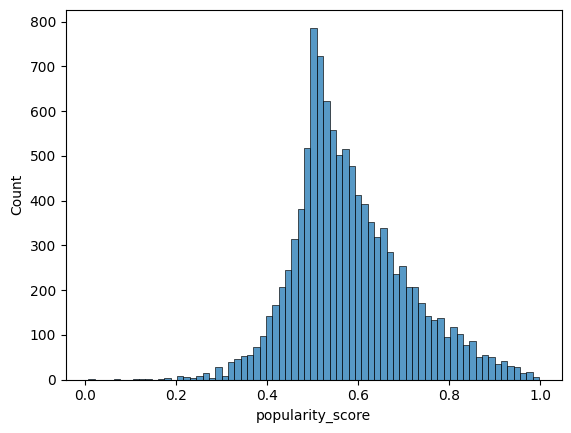

In [196]:
# distribution of popularity score is right skewed
sd.histplot(data = listingData, x = 'popularity_score')

The distribution of our popularity score consist of a right skewed.

<Axes: xlabel='price', ylabel='popularity_score'>

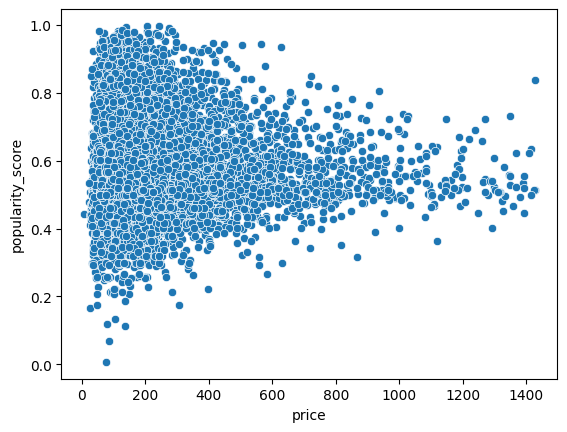

In [197]:
# affordability is a key factor as price increases the popularity score being a high score is less frequent
sd.scatterplot(data = listingData, x = 'price', y = 'popularity_score')





Graph suggest how as price increase the frequency of our popularity score being high decreases. Less people can afford the listing 
so then it has less number of reviews, decreasing popularity score

room_type
Shared room        0.478137
Hotel room         0.486808
Private room       0.563774
Entire home/apt    0.586905
Name: popularity_score, dtype: float64
room_type
Hotel room         0.463127
Shared room        0.500290
Private room       0.538359
Entire home/apt    0.566564
Name: popularity_score, dtype: float64


<Axes: xlabel='room_type', ylabel='popularity_score'>

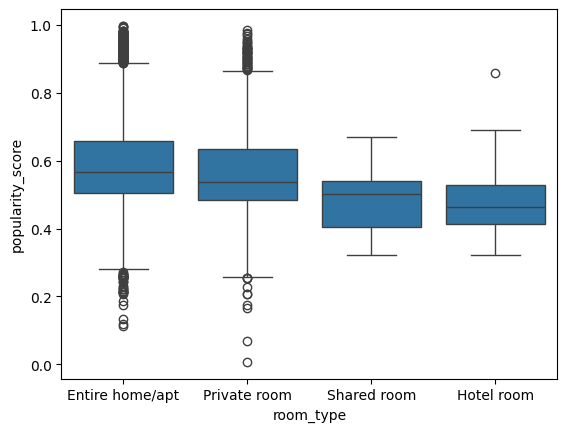

In [198]:
# average/median of popularity score is 0.03-0.10 higher within private room/entire home/apt comapred to shared/hotel room
print(listingData.groupby('room_type')['popularity_score'].mean().sort_values())
print(listingData.groupby('room_type')['popularity_score'].median().sort_values())

sd.boxplot(data = listingData, x = 'room_type', y = 'popularity_score')

Box plot consist for the 4 room types and we can see from the mean/median that the rooms which are private do better in popularity score
such as the entire home/apt and private room compared to shared spaces such as shared rooms and hotel rooms.

In [199]:
top = listingData[listingData['popularity_score'] > listingData['popularity_score'].quantile(0.75)]
avg = listingData[listingData['popularity_score'].between(
    listingData['popularity_score'].quantile(0.0), 
    listingData['popularity_score'].quantile(0.75)
)]

compare_cols = ['price', 'total_amenities', 'review_scores_rating', 
                'reviews_per_month', 'availability_30']

comparison = pd.DataFrame({
    'Top Listings': top[compare_cols].mean(),
    'Average Listings': avg[compare_cols].mean()
}).round(2)

print(comparison)

"""
Average in this case is the 0.75 quantile of data ranging from average and above
Top is an percentile above the 0.75 threshold
Top listings tend to have higher prices, more amenities, better review scores, 
and more reviews per month compared to average listings. Also, 
having lower availibility and these reveals how many features
contribute to the popularity(amount of reviews and review score) of a listing


"""

                      Top Listings  Average Listings
price                       201.67            231.62
total_amenities              47.79             45.56
review_scores_rating          4.90              4.82
reviews_per_month             4.31              2.18
availability_30              10.55             13.16


'\nAverage in this case is the 0.75 quantile of data ranging from average and above\nTop is an percentile above the 0.75 threshold\nTop listings tend to have higher prices, more amenities, better review scores, \nand more reviews per month compared to average listings. Also, \nhaving lower availibility and these reveals how many features\ncontribute to the popularity(amount of reviews and review score) of a listing\n\n\n'

Top listings compared to average tend to be more expensive, have more amenities, more reviews, and less availability.

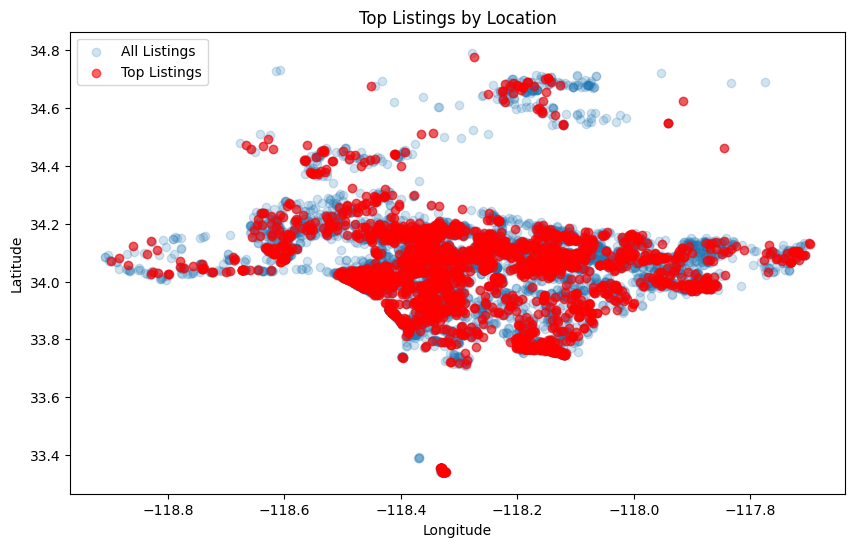

In [200]:
#Testing latitude and longitude
plt.figure(figsize=(10, 6))
plt.scatter(listingData['longitude'], listingData['latitude'], 
            alpha=0.2, label='All Listings')

# Highlight top listings
top = listingData[listingData['popularity_score'] > listingData['popularity_score'].quantile(0.75)]
plt.scatter(top['longitude'], top['latitude'], 
            color='red', alpha=0.6, label='Top Listings')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Top Listings by Location")
plt.show()

/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_2386/3742472292.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sd.kdeplot(


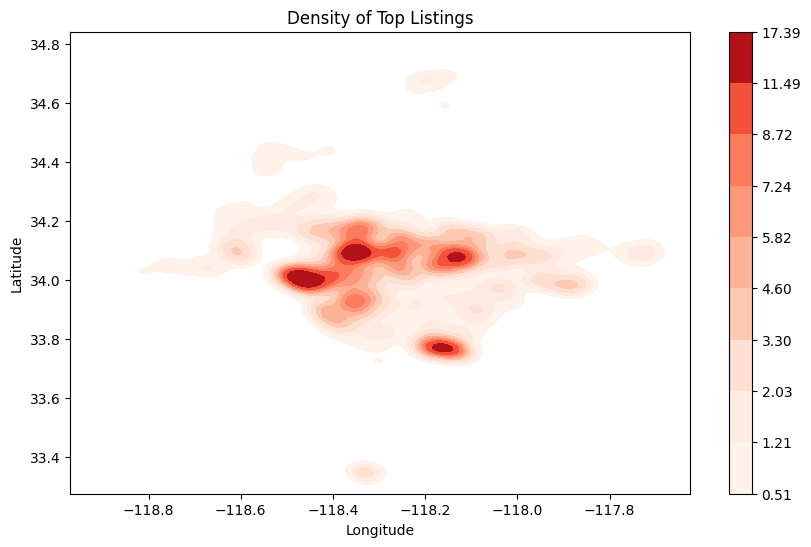

In [201]:
#Heat map of top listings
plt.figure(figsize=(10, 6))
top = listingData[listingData['popularity_score'] > listingData['popularity_score'].quantile(0.75)]

sd.kdeplot(
    data=top,
    x="longitude", y="latitude",
    cmap="Reds", shade=True, bw_adjust=0.5,
    cbar=True
)

plt.title("Density of Top Listings")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [202]:
import folium
'''
map of top listings revealing top listings located close to downtown of
Los Angeles or cities around downtown LA and also costal/beach areas.
'''
map_center = [top['latitude'].mean(), top['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=11)

# Add each top listing as a circle marker
for _, row in top.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.6,
        popup=f"Rating: {row['review_scores_rating']}, Reviews: {row['number_of_reviews_ltm']}"
    ).add_to(m)

m.save('top_listings_map.html')


Seen from our heat map and interactive maps top listings tend to be more in costal/beach areas and also downtown los angeles and its neighboring cities.

In [203]:
# created a df consisting of amenities and their count differences 
top_amenities = top.explode('amenities_list')
avg_amenities = avg.explode('amenities_list')

top_amenities_count = top_amenities['amenities_list'].value_counts()
avg_amenities_count = avg_amenities['amenities_list'].value_counts()

print(top_amenities_count)
print(avg_amenities_count)

compare_df = pd.DataFrame({
    'Top_Count': top_amenities_count,
    'Avg_Count': avg_amenities_count
}).fillna(0)

compare_df['Top_%'] = compare_df['Top_Count'] / len(top) * 100
compare_df['Avg_%'] = compare_df['Avg_Count'] / len(avg) * 100
compare_df['Top_vs_Avg_Diff'] = compare_df['Top_%'] - compare_df['Avg_%']

compare_df = compare_df.sort_values('Top_vs_Avg_Diff', ascending=False)

compare_df.describe()

                                

amenities_list
 Smoke alarm                                   2688
 Hot water                                     2677
 Hair dryer                                    2572
 Hangers                                       2556
 Carbon monoxide alarm                         2541
                                               ... 
 Echo Show Bluetooth sound system                 1
 Electric oven oven                               1
 Granier conditioner                              1
Bath and body body soap                           1
 Terra Pure H2O Tropical Infuse conditioner       1
Name: count, Length: 2199, dtype: int64
amenities_list
Smoke alarm                                                8043
Hot water                                                  7758
Carbon monoxide alarm                                      7517
Wifi                                                       7473
Hair dryer                                                 7363
                                      

,Top_Count,Avg_Count,Top_%,Avg_%,Top_vs_Avg_Diff
count,4582.000000,4582.000000,4582.000000,4582.000000,4582.000000
mean,29.333479,84.044959,1.070565,1.015649,0.054916
std,201.422403,586.775454,7.351183,7.090942,0.772883
min,0.000000,0.000000,0.000000,0.000000,-12.130968
25%,0.000000,1.000000,0.000000,0.012085,-0.012085
50%,0.000000,1.000000,0.000000,0.012085,-0.012085
75%,1.000000,2.000000,0.036496,0.024169,0.036496
max,2688.000000,8043.000000,98.102190,97.196375,11.491367


/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_2386/1176086893.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sd.barplot(data=top_diff, y=top_diff.index, x='Top_vs_Avg_Diff', palette='coolwarm')


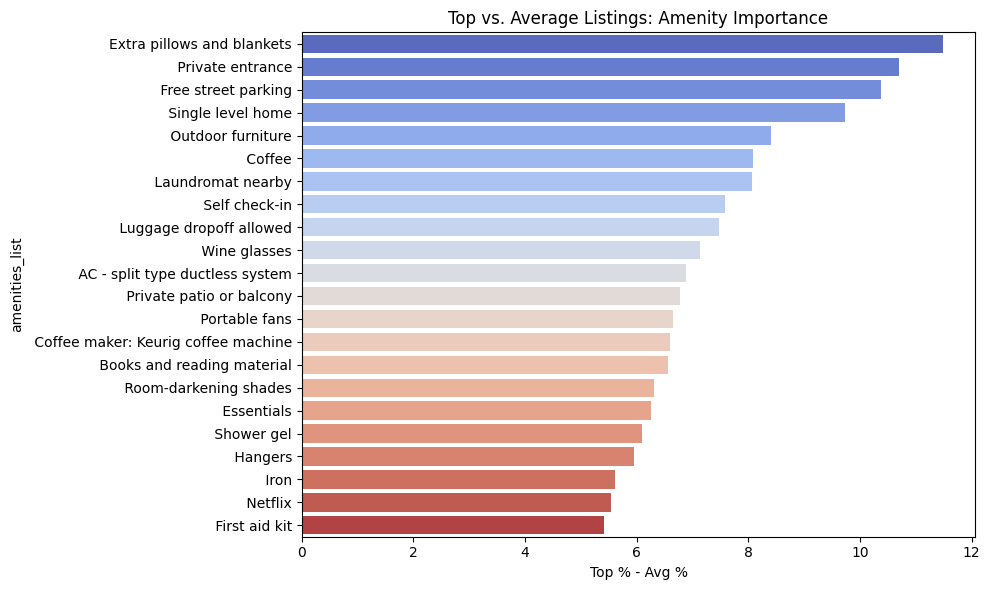

In [204]:
#Plot shows amenities that are more common in top listings compared to average listing
top_diff = compare_df[compare_df['Top_vs_Avg_Diff'] >= 5]

plt.figure(figsize=(10, 6))
sd.barplot(data=top_diff, y=top_diff.index, x='Top_vs_Avg_Diff', palette='coolwarm')
plt.xlabel('Top % - Avg %')
plt.title('Top vs. Average Listings: Amenity Importance')
plt.tight_layout()
plt.show()

The common top amenities with big differenes greater or equal to 5%
shows the common amenities that are more common in top listings compared
to average listing revealing how top listings differentiate themselves
from average listings. Amenities that are not basic but rather
thoughtful and quality-of-life features. 
 

In [205]:
# Find amenities that are more common in top listings compared to average listings
common_top_amenities = compare_df['Top_Count'].quantile(0.75)
top_common = compare_df[compare_df['Top_Count'] >= common_top_amenities]
big_impact_amenities = top_common[top_common['Top_vs_Avg_Diff'].abs() >= 5]

big_impact_amenities

,Top_Count,Avg_Count,Top_%,Avg_%,Top_vs_Avg_Diff
amenities_list,,,,,
Extra pillows and blankets,1241.0,2797.0,45.291971,33.800604,11.491367
Private entrance,1846.0,4690.0,67.372263,56.676737,10.695526
Free street parking,1839.0,4696.0,67.116788,56.749245,10.367544
Single level home,1134.0,2620.0,41.386861,31.661631,9.725230
Outdoor furniture,1474.0,3756.0,53.795620,45.389728,8.405892
Coffee,1635.0,4269.0,59.671533,51.589124,8.082409
Laundromat nearby,944.0,2183.0,34.452555,26.380665,8.071890
Self check-in,2326.0,6398.0,84.890511,77.317221,7.573290
Luggage dropoff allowed,1008.0,2426.0,36.788321,29.317221,7.471101


<Axes: xlabel='total_amenities', ylabel='popularity_score'>

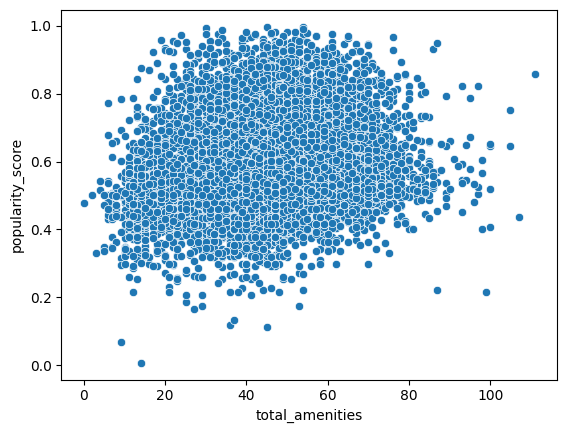

In [206]:
# shows amount of amenities do not impact the popularity score
sd.scatterplot(x = 'total_amenities', y = 'popularity_score', data = listingData)

Total amenities seen to not have a significant impact on popularity score

                             Top Listings  Average Listings  Difference
review_scores_cleanliness        4.883609          4.806845    0.076765
review_scores_accuracy           4.911328          4.840088    0.071240
review_scores_checkin            4.933318          4.882262    0.051055
review_scores_communication      4.946190          4.895316    0.050874
review_scores_location           4.858277          4.818742    0.039535


/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_2386/1139984414.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sd.barplot(data=review_diff, x='Difference', y='Review Category', palette='coolwarm')


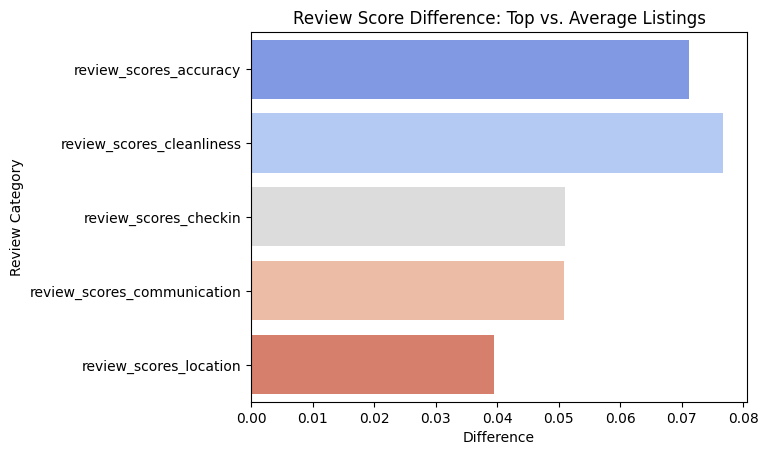

In [207]:
# subset of review score goes up review scores go up too

review_cols = [
    'review_scores_accuracy', 
    'review_scores_cleanliness', 
    'review_scores_checkin',
    'review_scores_communication', 
    'review_scores_location'
]

top_mean = top[review_cols].mean()
avg_mean = avg[review_cols].mean()

review_diff = pd.DataFrame({
    'Top Listings': top_mean,
    'Average Listings': avg_mean,
    'Difference': top_mean - avg_mean
})

print(review_diff.sort_values(by='Difference', ascending=False))

review_diff.reset_index(inplace=True)
review_diff.rename(columns={'index': 'Review Category'}, inplace=True)

sd.barplot(data=review_diff, x='Difference', y='Review Category', palette='coolwarm')
plt.title('Review Score Difference: Top vs. Average Listings')
plt.show()

Subsets of review scores are higher compared to the average listings and this 
is seen from our many analysis such as location(heat maps), check-in(amenities),
and communication(host response rate).
*cleanliness is strong too when comparing betwen top vs average

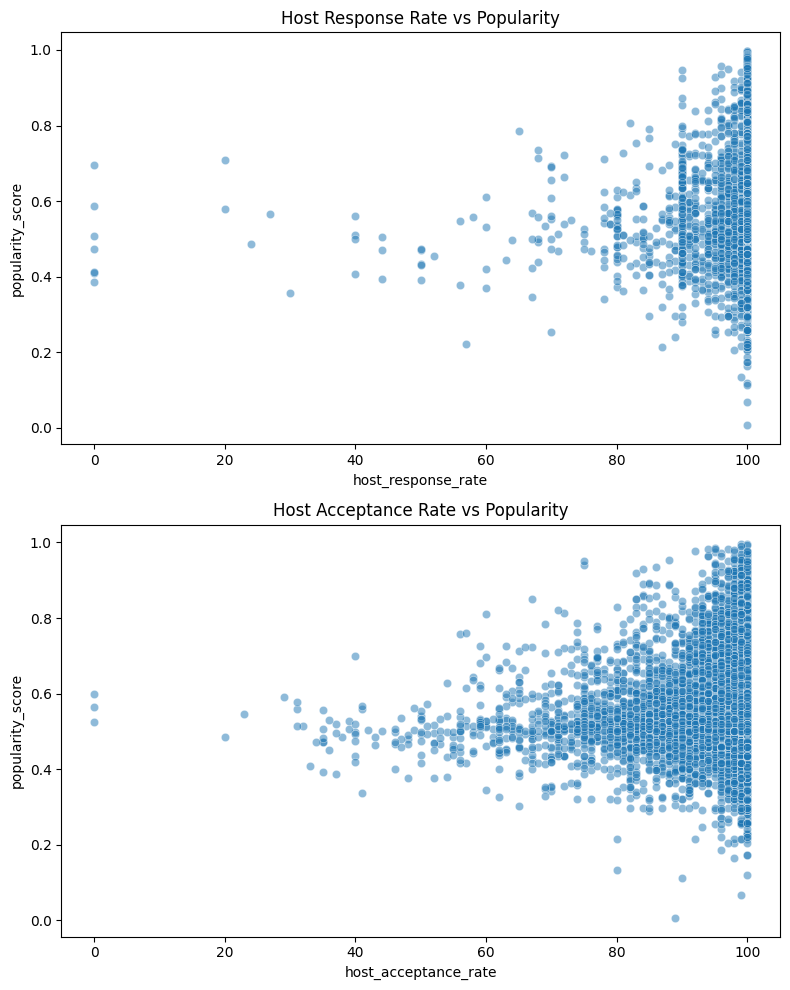

In [208]:

#200 unknowns out of 110000 listings so we can ignore them as not significant


no_unknowns_r = listingData[listingData['host_response_rate'] != 'unknown']   
no_unknowns_a = listingData[listingData['host_acceptance_rate'] != 'unknown']

fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # 2 rows, 1 column


sd.scatterplot(data=no_unknowns_r, x='host_response_rate', y='popularity_score', alpha=0.5, ax=axes[0])
axes[0].set_title('Host Response Rate vs Popularity')

sd.scatterplot(data=no_unknowns_a, x='host_acceptance_rate', y='popularity_score', alpha=0.5, ax=axes[1])
axes[1].set_title('Host Acceptance Rate vs Popularity')

plt.tight_layout()
plt.show()

plot reveals as host response rate and host acceptance rate increases the 
frequency of popularity score being high increases 

<Axes: xlabel='review_scores_accuracy', ylabel='popularity_score'>

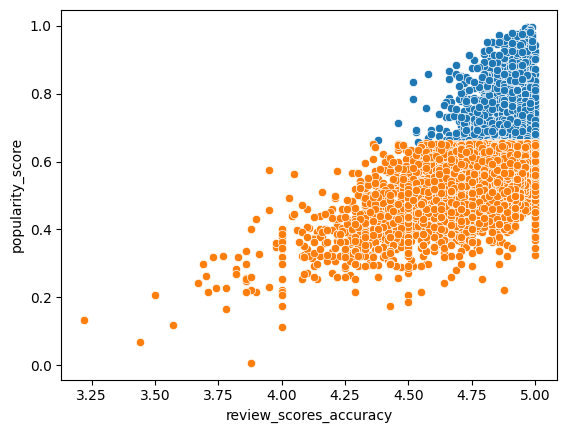

In [209]:

sd.scatterplot(data= top, x='review_scores_accuracy', y='popularity_score')
sd.scatterplot(data= avg, x='review_scores_cleanliness', y='popularity_score')

Cleanliness of listings plays a major role as top listings cleaniness
is almost always between 4.5-5.0 compared to average listing's cleanliness ranging 
all the way from 3.25-5.0